### Import PyTorch

In [1]:
import torch
from torch import nn

print(torch.__version__)

2.7.1+cu128


### Check CUDA enabled

In [2]:
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
if torch.cuda.is_available():
    print("Device count:", torch.cuda.device_count())
    print("GPU name:", torch.cuda.get_device_name(0))

Torch version: 2.7.1+cu128
CUDA available: True
CUDA version: 12.8
Device count: 1
GPU name: NVIDIA GeForce RTX 3060 Laptop GPU


### Create Data

In [3]:
import sklearn
from sklearn.datasets import make_circles

# Create 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples, 
                    noise=0.03,
                    random_state=42)

print(len(X), len(y))
X[:5], y[:5]

1000 1000


(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

In [4]:
# Make DataFrame of circle data
import pandas as pd

circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label":y})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


### Visualize Data

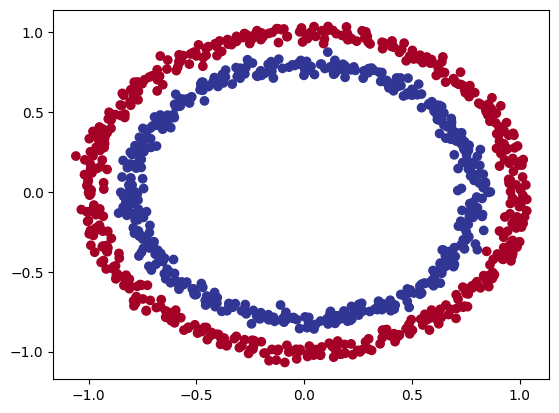

In [5]:
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

""" Taken from Daniel Bourke's github:
https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py
"""

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


### Split data into training and test set

In [7]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], X.dtype, y[:5], y.dtype

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 torch.float32,
 tensor([1., 1., 1., 1., 0.]),
 torch.float32)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

print(len(X_train), len(y_train))

800 800


In [10]:
X.shape, y.shape

(torch.Size([1000, 2]), torch.Size([1000]))

### Build Binary Classification Model

In [35]:
class CircleClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=2, out_features=64),
            nn.ReLU(),   # 
            nn.Linear(in_features=64, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=1)
        )

    def forward(self, x):
        return self.linear_layers(x)
    
model = CircleClassifier()
model, model.state_dict()


(CircleClassifier(
   (linear_layers): Sequential(
     (0): Linear(in_features=2, out_features=64, bias=True)
     (1): ReLU()
     (2): Linear(in_features=64, out_features=64, bias=True)
     (3): ReLU()
     (4): Linear(in_features=64, out_features=1, bias=True)
   )
 ),
 OrderedDict([('linear_layers.0.weight',
               tensor([[ 0.7003, -0.3907],
                       [-0.3000, -0.5009],
                       [ 0.5267,  0.4263],
                       [-0.0392,  0.4377],
                       [-0.4885,  0.3837],
                       [-0.2130,  0.2807],
                       [ 0.5044,  0.2965],
                       [-0.1195,  0.0800],
                       [ 0.3092, -0.6766],
                       [-0.0652,  0.6274],
                       [ 0.4635, -0.2962],
                       [ 0.3582, -0.3969],
                       [ 0.3483,  0.3153],
                       [-0.1027,  0.2039],
                       [ 0.6866, -0.1597],
                       [-0.1009, -0.682

### Training model

In [36]:
model = CircleClassifier()

In [37]:
# Loss function
loss_fn = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = torch.optim.Adam(params=model.parameters(),
                            lr=0.001)

# Number of epochs (loops)
epochs = 100

# Initialize empty lists to store values
epoch_count = []
loss_values = []
test_loss_values = []

# Accuracy function
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

In [38]:
torch.manual_seed(42)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model.train()   # sets all parameters that require gradients to require gradients
    
    # 1. Forward pass
    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))   # logits -> prediction probabilities - > prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits,
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)
    
    # 3. Zero the gradients of the optimizer
    optimizer.zero_grad()

    # 4. Perform backpropagation on the loss with respect to parameters of the model
    loss.backward()

    # 5. Step the optimizer (perform gradient descent)
    optimizer.step()

    ### Testing
    model.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate loss
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test, 
                               y_pred=test_pred)
    
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {acc:.2f} | Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69351 | Accuracy: 45.62 | Test Loss: 0.69275 | Test Accuracy: 53.00%
Epoch: 10 | Loss: 0.68395 | Accuracy: 53.00 | Test Loss: 0.68514 | Test Accuracy: 54.50%
Epoch: 20 | Loss: 0.67439 | Accuracy: 70.62 | Test Loss: 0.67673 | Test Accuracy: 67.50%
Epoch: 30 | Loss: 0.66166 | Accuracy: 78.88 | Test Loss: 0.66565 | Test Accuracy: 76.50%
Epoch: 40 | Loss: 0.64438 | Accuracy: 86.50 | Test Loss: 0.65067 | Test Accuracy: 84.50%
Epoch: 50 | Loss: 0.62118 | Accuracy: 94.25 | Test Loss: 0.62953 | Test Accuracy: 91.00%
Epoch: 60 | Loss: 0.59069 | Accuracy: 98.12 | Test Loss: 0.60172 | Test Accuracy: 96.50%
Epoch: 70 | Loss: 0.55256 | Accuracy: 99.62 | Test Loss: 0.56680 | Test Accuracy: 98.50%
Epoch: 80 | Loss: 0.50772 | Accuracy: 99.88 | Test Loss: 0.52530 | Test Accuracy: 98.50%
Epoch: 90 | Loss: 0.45642 | Accuracy: 99.88 | Test Loss: 0.47767 | Test Accuracy: 98.50%


#### Make prediction

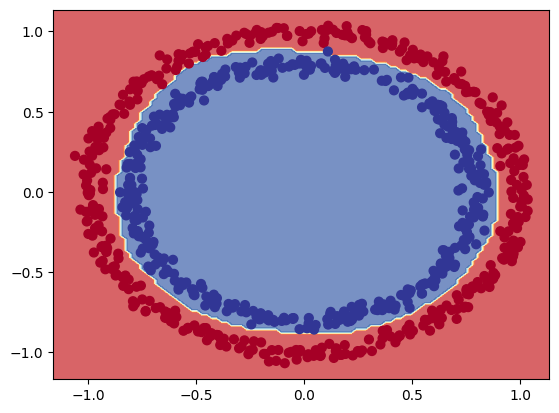

In [39]:
with torch.inference_mode():
    y_pred = torch.round(torch.sigmoid(model(X_test))).squeeze

plot_decision_boundary(model, X_train, y_train)

### Plot loss curve

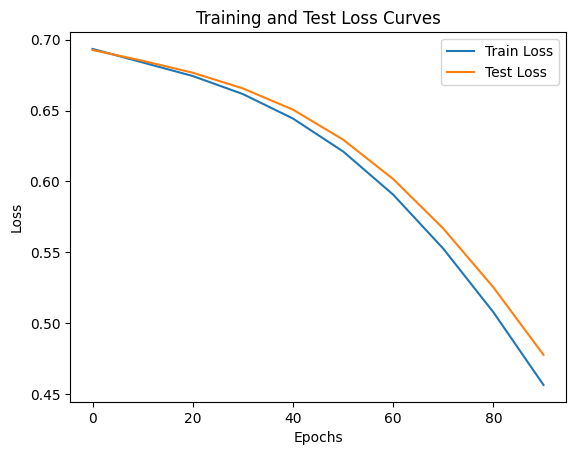

In [40]:
import numpy as np

plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train Loss")
plt.plot(epoch_count, test_loss_values, label="Test Loss")
plt.title("Training and Test Loss Curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
